In [1]:
import pandas as pd
import numpy as np
import pickle

import torch

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForSequenceClassification, BertAdam

from sklearn.metrics import accuracy_score, matthews_corrcoef, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score

from matplotlib import pyplot as plt

import random
import math
import time

In [2]:
df = pd.read_csv('assets/df_cleaned.csv')

In [3]:
df.head()

,tweet_id,tweet_text,class_label,file_name,event,year,event_type,data_type,tweet_text_cleaned,hashtags,class_label_id,processed_text_length
0,1.065845e+18,"Camp Fire leaves over 13,000 without homes thi...",displaced_people_and_evacuations,california_wildfires_2018_dev.tsv,california_wildfires_2018,2018,fire,dev,camp fire leaves over without homes this thank...,[],0,123.0
1,1.061321e+18,"So in a truly strange world, we have @RealJame...",not_humanitarian,california_wildfires_2018_dev.tsv,california_wildfires_2018,2018,fire,dev,so in a truly strange world we have playing th...,[],1,148.0
2,1.063536e+18,66 people have died and more than 600 are stil...,injured_or_dead_people,california_wildfires_2018_dev.tsv,california_wildfires_2018,2018,fire,dev,people have died and more than are still missi...,"['californiawildfires', 'cafire', 'campfire', ...",2,61.0
3,1.062711e+18,BBC News - California wildfires: Nine dead and...,injured_or_dead_people,california_wildfires_2018_dev.tsv,california_wildfires_2018,2018,fire,dev,bbc news california wildfires nine dead and mo...,[],2,63.0
4,1.064808e+18,Death toll in California’s #CampFire has climb...,injured_or_dead_people,california_wildfires_2018_dev.tsv,california_wildfires_2018,2018,fire,dev,death toll in californias has climbed to the n...,['campfire'],2,219.0


In [4]:
train_size = int(0.8 * len(df))
val_size = int(0.1 * len(df))
test_sie = len(df) - train_size - val_size
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), [train_size, train_size + val_size])

In [5]:
len(df_train), len(df_val), len(df_test)

(61186, 7648, 7649)

In [6]:
class BertLSTMModel(nn.Module):

    def __init__(self, n_class, dropout_rate, device, bert_config='bert-base-uncased'):

        super(BertLSTMModel, self).__init__()

        self.n_class = n_class
        self.bert_config = bert_config
        self.bert = BertModel.from_pretrained(self.bert_config)
        self.tokenizer = BertTokenizer.from_pretrained(self.bert_config)
        self.lstm_hidden_size = self.bert.config.hidden_size
        self.dropout_rate = dropout_rate
        self.lstm = nn.LSTM(self.bert.config.hidden_size, self.lstm_hidden_size, bidirectional=True)
        self.hidden_to_softmax = nn.Linear(self.lstm_hidden_size * 2, n_class, bias=True)
        self.dropout = nn.Dropout(p=self.dropout_rate)
        self.device = device

    def forward(self, sents):
        
        sents_tensor, masks_tensor, sents_lengths = self.sents2tensor(sents)
        #sents_lengths = torch.tensor([len(sent) for sent in sents], device=self.device)
        encoded_layers, pooled_output = self.bert(input_ids=sents_tensor, attention_mask=masks_tensor,
                                                  output_all_encoded_layers=False)
        encoded_layers = encoded_layers.permute(1, 0, 2)
        enc_hiddens, (last_hidden, last_cell) = self.lstm(pack_padded_sequence(encoded_layers, sents_lengths))
        output_hidden = torch.cat((last_hidden[0], last_hidden[1]), dim=1)  # (batch_size, 2*hidden_size)
        output_hidden = self.dropout(output_hidden)
        pre_softmax = self.hidden_to_softmax(output_hidden)

        return pre_softmax
    
    def add_special_token(self, sents_token, cls_token='[CLS]', sep_token='[SEP]'):
        return [[cls_token] + sent + [sep_token] for sent in sents_token]
    
    def pad_sents(self, sents_token, pad_token):
        sents_padded = []
        max_len = max(len(s) for s in sents_token)
        for s in sents_token:
            padded = [pad_token] * max_len
            padded[:len(s)] = s
            sents_padded.append(padded)
        return sents_padded
    
    def sents2tensor(self, sents):
        tokens_list = [self.tokenizer.tokenize(sent) for sent in sents]
        tokens_list_added = self.add_special_token(tokens_list)
        sents_lengths = [len(tokens) for tokens in tokens_list_added]
        tokens_sents_zip = zip(tokens_list_added, sents_lengths)
        tokens_sents_zip = sorted(tokens_sents_zip, key=lambda x: x[1], reverse=True)
        tokens_list_added, sents_lengths = zip(*tokens_sents_zip)
        sents_lengths = torch.tensor(sents_lengths, device=self.device)
        tokens_list_padded = self.pad_sents(tokens_list_added, '[PAD]')

        masks = []
        for tokens in tokens_list_padded:
            mask = [0 if token=='[PAD]' else 1 for token in tokens]
            masks.append(mask)
        masks_tensor = torch.tensor(masks, dtype=torch.long, device=self.device)
        tokens_id_list = [self.tokenizer.convert_tokens_to_ids(tokens) for tokens in tokens_list_padded]
        sents_tensor = torch.tensor(tokens_id_list, dtype=torch.long, device=self.device)
        return sents_tensor, masks_tensor, sents_lengths
    
    def load(model_path):
        params = torch.load(model_path)
        args = params['args']
        model = BertLSTMModel(**args)
        model.load_state_dict(params['state_dict'])

        return model

    def save(self, model_path):
        print('save model parameters to [%s]' % model_path)

        params = {
            'args': dict(bert_config=self.bert_config, n_class=self.n_class, 
                         dropout_rate=self.dropout_rate, device=self.device),
            'state_dict': self.state_dict()
        }

        torch.save(params, model_path)

In [7]:
N_CLASS = 10
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BERT_CONFIG = 'C:\\bert\\bert-base-uncased'

model = BertLSTMModel(n_class=N_CLASS, dropout_rate=0.0, device=DEVICE, bert_config=BERT_CONFIG)

In [8]:
model.forward(df_train['tweet_text_cleaned'][0])

tensor([[-0.0280,  0.0430,  0.0825,  ...,  0.0297, -0.0120, -0.0270],
        [-0.0132,  0.1304,  0.0391,  ...,  0.0686,  0.0068, -0.0094],
        [-0.1133,  0.0455,  0.0897,  ...,  0.0930, -0.0377, -0.0456],
        ...,
        [-0.0499, -0.0089,  0.0886,  ...,  0.0311, -0.0170, -0.0327],
        [-0.0341, -0.0143,  0.0332,  ...,  0.0732, -0.0133, -0.0386],
        [-0.0518, -0.0048, -0.0132,  ...,  0.0638, -0.0541, -0.0211]],
       grad_fn=<AddmmBackward>)

In [9]:
def batch_iter(data, batch_size, shuffle=False):
    batch_num = math.ceil(data.shape[0] / batch_size)
    index_array = list(range(data.shape[0]))

    if shuffle:
        data = data.sample(frac=1)

    for i in range(batch_num):
        indices = index_array[i * batch_size: (i + 1) * batch_size]

        examples = data.iloc[indices].sort_values(by='processed_text_length', ascending=False)
        sents = list(examples['tweet_text_cleaned'])
        targets = list(examples['class_label_id'].values)
        yield sents, targets  # list[list[str]], list[int]

In [10]:
def validate(model, df, loss_function, device):
    was_training = model.training
    model.eval()
    
    df = df.sort_values(by='processed_text_length', ascending=False)
    sents = df['tweet_text_cleaned'].values
    labels = df['class_label_id'].values
    
    with torch.no_grad():
        pre_softmax = model(sents)
        loss = loss_function(pre_softmax, torch.tensor(labels, dtype=torch.long, device=device))

        softmax = torch.nn.Softmax(dim=1)
        prob = softmax(pre_softmax)
        prediction = [t.item() for t in list(torch.argmax(prob, dim=1))]

    if was_training:
        model.train()

    return loss.item(), accuracy_score(labels, prediction)

In [11]:
def train(model, df_train, df_val, lr, clip_grad, batch_size, log_every, epoch):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    train_label = dict(df_train['class_label_id'].value_counts())
    label_max = float(max(train_label.values()))
    train_label_weight = torch.tensor([label_max/train_label.get(i, label_max) for i in range(10)], dtype=torch.float)

    model = model.to(device)

    model.train()
    optimizer = BertAdam([
                {'params': model.bert.parameters()},
                {'params': model.lstm.parameters(), 'lr': lr},
                {'params': model.hidden_to_softmax.parameters(), 'lr': lr}
            ], lr=lr, max_grad_norm=clip_grad)
    cn_loss = torch.nn.CrossEntropyLoss(weight=train_label_weight, reduction='mean')
    torch.save(cn_loss, 'loss_func')  # for later testing

    train_iter = patience = cum_loss = report_loss = 0
    cum_examples = report_examples = 0
    train_time = begin_time = time.time()
    print('Begin Training...')

    for i in range(epoch):
        for sents, targets in batch_iter(df_train, batch_size=batch_size, shuffle=True):  # for each epoch
            train_iter += 1

            optimizer.zero_grad()

            pre_softmax = model(sents)

            loss = cn_loss(pre_softmax, torch.tensor(targets, dtype=torch.long, device=device))

            loss.backward()

            # clip gradient
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

            optimizer.step()

            batch_losses = loss.item() * batch_size
            report_loss += batch_losses
            cum_loss += batch_losses

            report_examples += batch_size
            cum_examples += batch_size
            
            if train_iter % log_every == 0:
                print('epoch %d/%d, iter %d, avg. loss %.2f, '
                      'cum. examples %d, speed %.2f examples/sec, '
                      'time elapsed %.2f sec' % (i+1, epoch, train_iter,
                                                 report_loss / report_examples,
                                                 cum_examples,
                                                 report_examples / (time.time() - train_time),
                                                 time.time() - begin_time))

                train_time = time.time()
                report_loss = report_examples = 0.
        
#         train_loss, train_acc = evaluate(model, df_train, cn_loss)
        val_loss, val_acc = validate(model, df_val, cn_loss, device)
        
        print('Validation: epoch %d/%d '
              'avg validation loss %.2f, validation accuracy %.2f '% (i+1, epoch,
                                         val_loss, val_acc))

In [12]:
train(model, df_train[:100], df_val[:100], lr=0.001, clip_grad=1.0, batch_size=100, log_every=10, epoch=2)

t_total value of -1 results in schedule not being applied


Begin Training...
Validation: epoch 1/2 avg validation loss 2.42, validation accuracy 0.00 
Validation: epoch 2/2 avg validation loss 2.28, validation accuracy 0.25 


In [13]:
model.save('models/bert+lstm')

save model parameters to [models/bert+lstm]


In [16]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = BertLSTMModel.load(model_path='models/bert+lstm')
model.to(DEVICE)
model.eval()

BertLSTMModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
     

In [17]:
df_test = df_test.sort_values(by='processed_text_length', ascending=False)
test_sents = df_test['tweet_text_cleaned'].values
test_labels = df_test['class_label_id'].values

In [18]:
with torch.no_grad():
    pre_softmax = model(test_sents)
    cn_loss = torch.load('loss_func').to(DEVICE)
    loss = cn_loss(pre_softmax, torch.tensor(test_labels, dtype=torch.long, device=DEVICE))

    softmax = torch.nn.Softmax(dim=1)
    prob = softmax(pre_softmax)
    prediction = [t.item() for t in list(torch.argmax(prob, dim=1))]

In [19]:
df_test['predict_label'] = prediction

In [20]:
df_test

,tweet_id,tweet_text,class_label,file_name,event,year,event_type,data_type,tweet_text_cleaned,hashtags,class_label_id,processed_text_length,predict_label
18681,1.167540e+18,GOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...,not_humanitarian,hurricane_dorian_2019_train.tsv,hurricane_dorian_2019,2019,hurricane,train,gooooooooooooooooooooooooooooooooooooooooooooo...,[],1,280.0,1
3845,1.065500e+18,@GaetaSusan @POTUS What is believed is happeni...,not_humanitarian,california_wildfires_2018_train.tsv,california_wildfires_2018,2018,fire,train,what is believed is happening in california is...,[],1,280.0,1
66809,1.032260e+18,@PMOIndia Sir now Kerala needs such a project ...,infrastructure_and_utility_damage,kerala_floods_2018_train.tsv,kerala_floods_2018,2018,flood,train,sir now kerala needs such a project for the fl...,[],3,279.0,1
5435,1.067657e+18,The wife and i have been staying at the red cr...,rescue_volunteering_or_donation_effort,california_wildfires_2018_train.tsv,california_wildfires_2018,2018,fire,train,the wife and i have been staying at the red cr...,[],5,278.0,5
2719,1.065576e+18,@realDonaldTrump California has been wet some ...,not_humanitarian,california_wildfires_2018_train.tsv,california_wildfires_2018,2018,fire,train,california has been wet some years and dry oth...,[],1,277.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16091,1.168301e+18,RT @SamGonzales: Donate to @WCKitchen #Dorian2...,rescue_volunteering_or_donation_effort,hurricane_dorian_2019_test.tsv,hurricane_dorian_2019,2019,hurricane,test,donate to,"['dorian2019', 'hurricanedorian2019', 'abacos'...",5,9.0,1
67313,1.031005e+18,Pray fir #KeralaFloodRelief,sympathy_and_support,kerala_floods_2018_train.tsv,kerala_floods_2018,2018,flood,train,pray fir,['keralafloodrelief'],6,8.0,5
43934,9.067310e+17,Kindness #HurricaneIrma #IrmaHurricane2017 #ev...,sympathy_and_support,hurricane_irma_2017_train.tsv,hurricane_irma_2017,2017,hurricane,train,kindness,"['hurricaneirma', 'irmahurricane2017', 'evacua...",6,8.0,5
18971,1.167958e+18,#242outof365days Evac day. #242 #242outof365 #...,displaced_people_and_evacuations,hurricane_dorian_2019_train.tsv,hurricane_dorian_2019,2019,hurricane,train,evac day,"['242outof365days', '242', '242outof365', 'hur...",0,8.0,5


In [ ]:
#df_test.to_csv('prediction.csv', index=False)

In [21]:
df_test[df_test['class_label_id'] != df_test['predict_label']]['predict_label'].value_counts()

1    4638
5    1437
6     531
Name: predict_label, dtype: int64

In [22]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, path='cm', cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     pickle.dump(cm, open(path, 'wb'))

    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [23]:
label_name = sorted(df['class_label'].unique())

C:\Users\Di Lin\Anaconda3\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Di Lin\Anaconda3\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Di Lin\Anaconda3\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Di Lin\Anaconda3\envs\capstone\lib\site-packages\sklearn\metrics

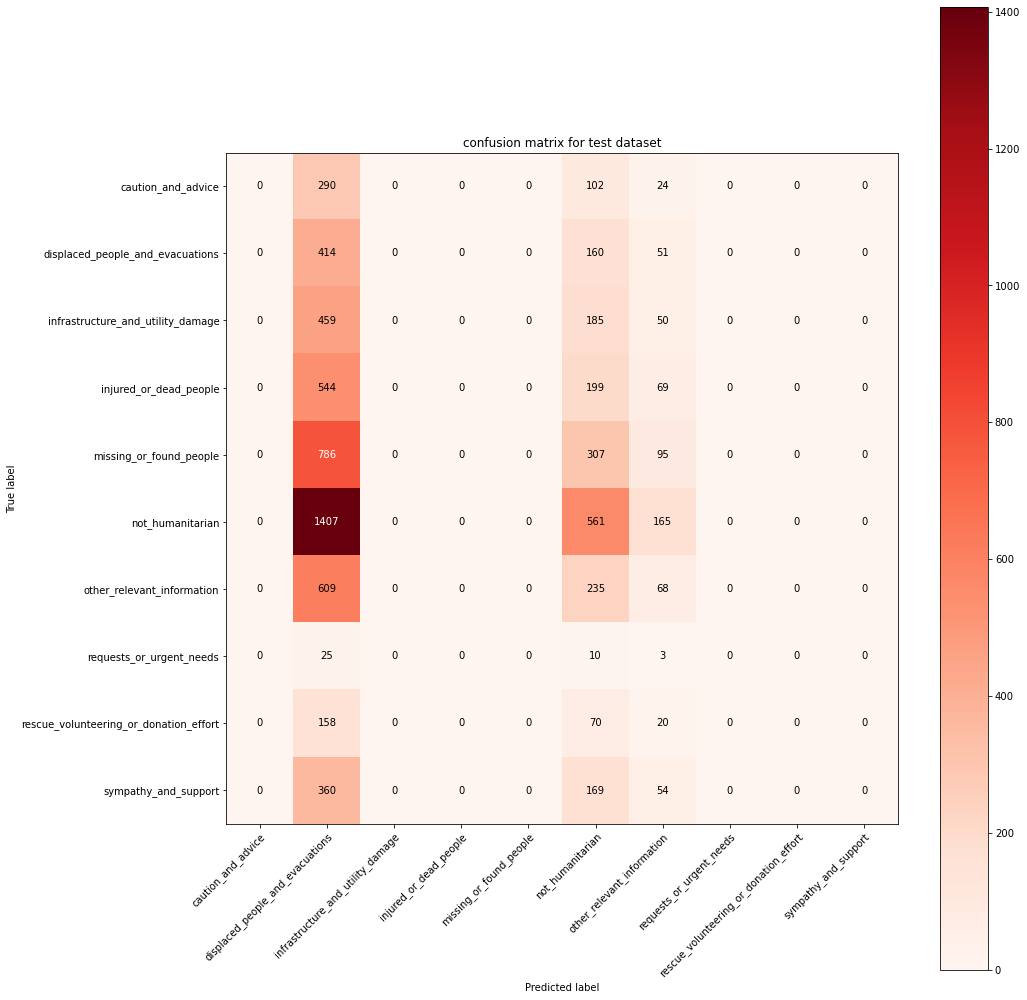

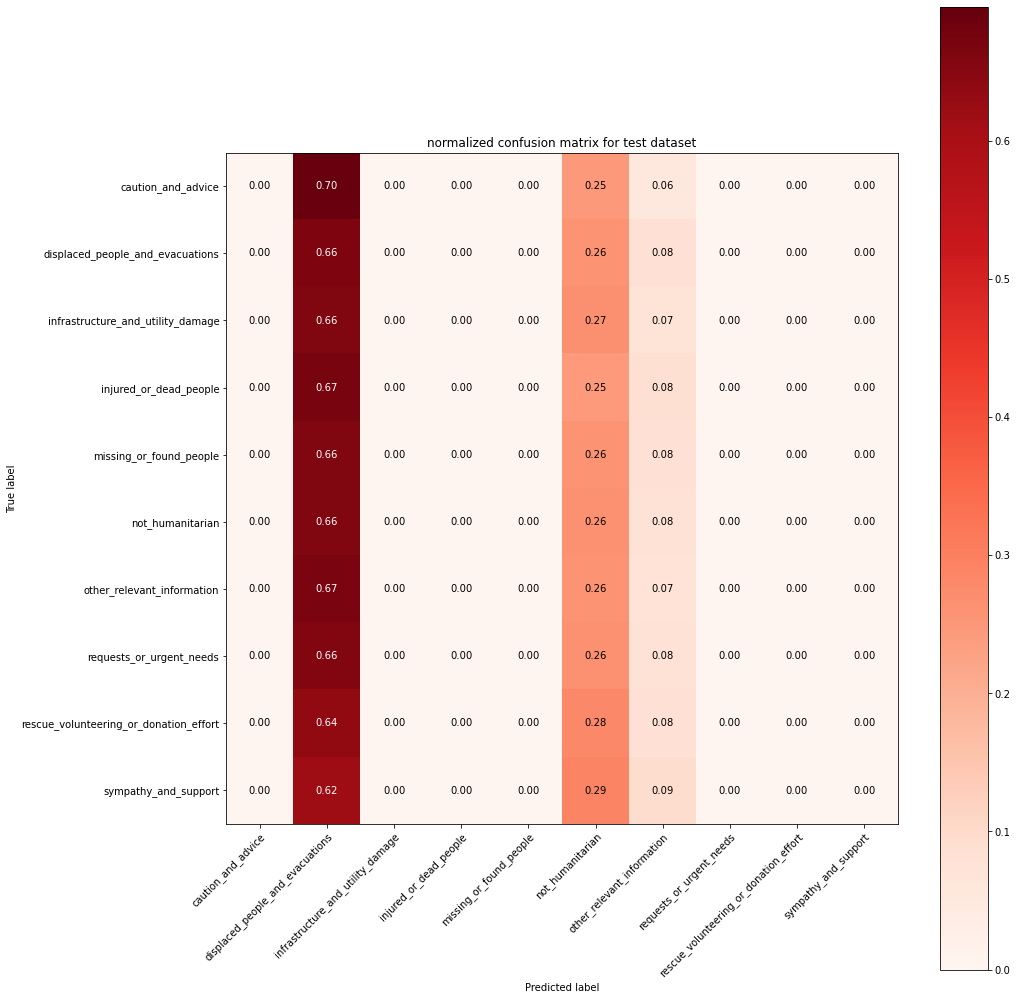

In [24]:
accuracy = accuracy_score(df_test['class_label_id'], prediction)
matthews = matthews_corrcoef(df_test['class_label_id'], prediction)

precisions = {}
recalls = {}
f1s = {}
aucrocs = {}

for i in range(len(label_name)):
    prediction_ = [1 if pred == i else 0 for pred in prediction]
    true_ = [1 if label == i else 0 for label in df_test['class_label_id']]
    f1s.update({label_name[i]: f1_score(true_, prediction_)})
    precisions.update({label_name[i]: precision_score(true_, prediction_)})
    recalls.update({label_name[i]: recall_score(true_, prediction_)})
    aucrocs.update({label_name[i]: roc_auc_score(true_, list(t.item() for t in prob[:, i]))})

metrics_dict = {'loss': loss, 'accuracy': accuracy, 'matthews coef': matthews, 'precision': precisions,
                     'recall': recalls, 'f1': f1s, 'aucroc': aucrocs}

pickle.dump(metrics_dict, open('evaluation_metrics', 'wb'))

cm = plot_confusion_matrix(list(df_test['class_label_id']), prediction, label_name, normalize=False,
                      path='test_confusion_matrix', title='confusion matrix for test dataset')
plt.savefig('test_confusion_matrix', format='png')
cm_norm = plot_confusion_matrix(list(df_test['class_label_id']), prediction, label_name, normalize=True,
                      path='test normalized_confusion_matrix', title='normalized confusion matrix for test dataset')
plt.savefig('test_normalized_confusion_matrix', format='png')

# print('loss: %.2f' % loss)
# print('accuracy: %.2f' % accuracy)
# print('matthews coef: %.2f' % matthews)
# for i in range(len(label_name)):
#     print('precision score for %s: %.2f' % (label_name[i], precisions[label_name[i]]))
#     print('recall score for %s: %.2f' % (label_name[i], recalls[label_name[i]]))
#     print('f1 score for %s: %.2f' % (label_name[i], f1s[label_name[i]]))
#     print('auc roc score for %s: %.2f' % (label_name[i], aucrocs[label_name[i]]))